# 图像增广
- 使用pytorch中图像增广来改变图像，并且对cifar10数据集进行训练。

## 1 加载库文件

In [1]:
import numpy as np
from PIL import Image
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## 2 对实例图像进行图像增广

### 2.1 加载原图片

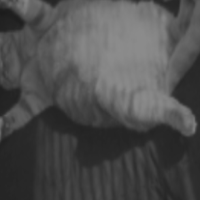

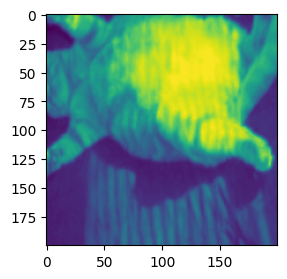

In [2]:
plt.figure(num = 0, figsize=(3, 3))
a = Image.open("cat.png").convert("L")
trans = torchvision.transforms.Compose([transforms.RandomHorizontalFlip(), 
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
                                        transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))])
b = trans(a)
plt.imshow(b)
b

PIL.PngImagePlugin.PngImageFile

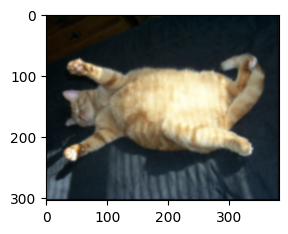

In [3]:
plt.figure(num = 1, figsize=(3, 3))
img1 = Image.open("cat.png")
plt.imshow(img1)
type(img1)

### 2.2 显示图片

In [4]:
def show_image(imgs, num_rows, num_cols, titles = None):
    figsize = (10, 3)
    _, axes = plt.subplots(num_rows, num_cols, figsize = figsize, num = 1)
    axes = axes.flatten()
    for i, ax, img in zip(range(len(imgs)), axes, imgs):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
    plt.show()
    return axes

In [5]:
def apply(img, aug, num_rows = 2, num_cols = 4):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_image(Y, num_rows, num_cols)

### 2.3 水平翻转

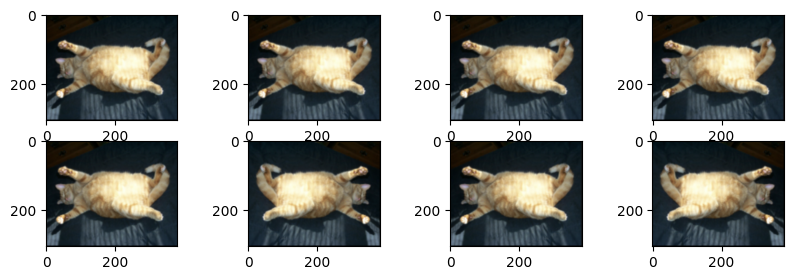

In [6]:
apply(img1, transforms.RandomHorizontalFlip(p = 0.5))

### 2.4 垂直翻转

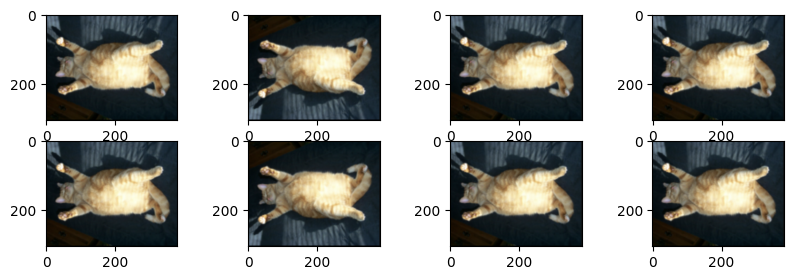

In [7]:
apply(img1, transforms.RandomVerticalFlip(p = 0.5))

### 2.5 图像裁剪

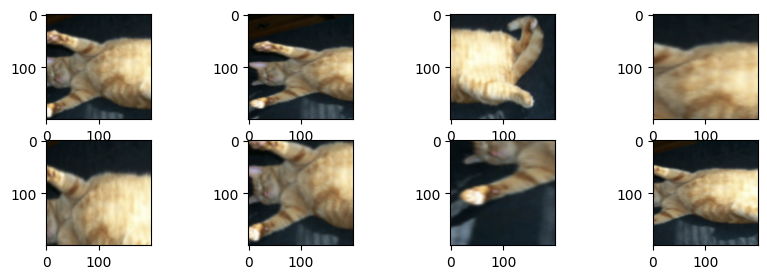

In [8]:
shape_aug = transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img1, shape_aug)

### 2.6 改变亮度

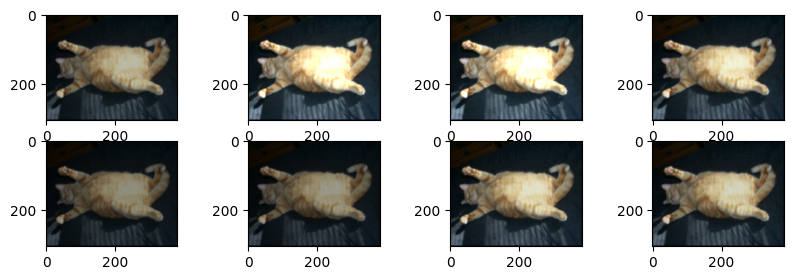

In [9]:
apply(img1, transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

### 2.7 改变颜色

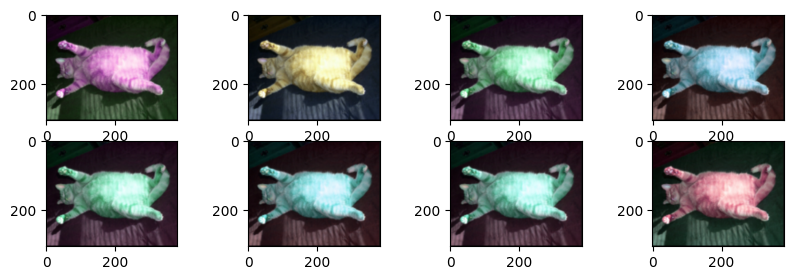

In [10]:
apply(img1, transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

### 2.8 同时改变亮度，对比度，饱和度，色调

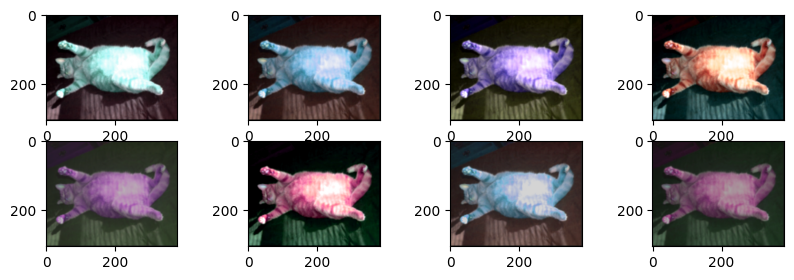

In [11]:
color_aug = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img1, color_aug)

### 2.9 多种图像增广方法

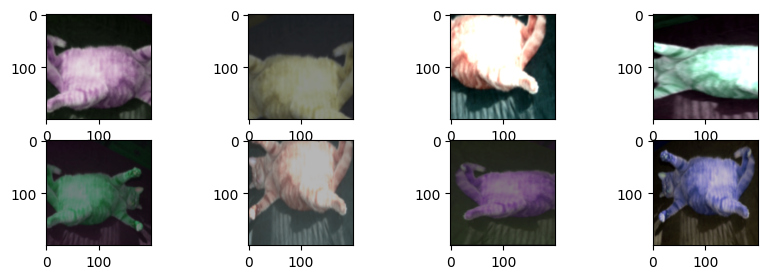

In [12]:
augs = transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img1, augs)

## 3 使用图像增广进行训练

### 3.1 显示图片

Files already downloaded and verified


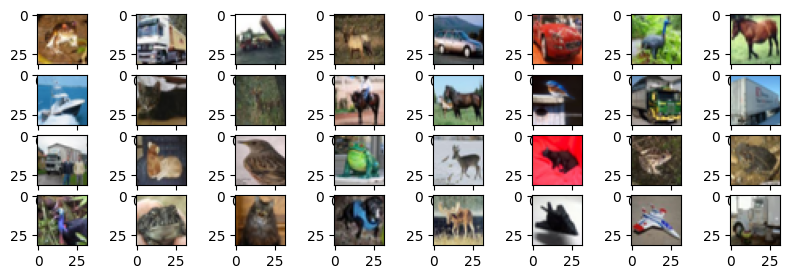

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

In [13]:
all_images = torchvision.datasets.CIFAR10(train=True, root="C:/Users/CCU6/Practice/pytorch/data/CIFAR-10",download = True)
show_image([all_images[i][0] for i in range(32)], 4, 8)

### 3.2 将图片加载为灰度图

In [14]:
train_trans = transforms.Compose([transforms.Resize([224, 224]), 
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.Grayscale(num_output_channels=1), # 彩色图像转灰度图像num_output_channels默认1
                                  transforms.ToTensor()])
test_trans = torchvision.transforms.Compose([transforms.Resize([224, 224]), 
                                             transforms.Grayscale(num_output_channels=1), 
                                             transforms.ToTensor()])
train = torchvision.datasets.CIFAR10(train = True, root = "C:/Users/CCU6/Practice/pytorch/data/CIFAR-10", transform = train_trans, download = True)
validation = torchvision.datasets.CIFAR10(train = False, root = "C:/Users/CCU6/Practice/pytorch/data/CIFAR-10", transform = test_trans, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
len(train), len(validation)

(50000, 10000)

## 4 定义ResNet模型

### 4.1 自定义Restidual类

In [16]:
class Restidual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides = 1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = num_channels, 
                               kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.Conv2d(in_channels = num_channels, out_channels = num_channels, 
                               kernel_size = 3, padding = 1, stride = 1)
        if use_1x1conv == True:
            self.conv3 = nn.Conv2d(in_channels = input_channels, out_channels = num_channels, 
                                   kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 != None:
            X = self.conv3(X)
        Y += X
        
        return F.relu(Y)

### 4.2 自定义resnet块

In [17]:
def resnet_block(input_channels, num_channels, num_restiduals, first_block = True):
    blk = []
    for i in range(num_restiduals):
        if (i == 0) and (first_block == True):
            blk.append(Restidual(input_channels, num_channels, use_1x1conv = True, strides = 2))
        else:
            blk.append(Restidual(num_channels, num_channels))
    return blk

In [18]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block = False))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [19]:
net1 = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 176))

In [20]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net1:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 176])


## 5 训练模型

### 5.1 绘制动图

In [21]:
def plot_image(num, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc):
    plt.figure(num = num)
    plt.ion()
    plt.cla()
    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax1.set_xlim((0, num_epochs))
    #ax1.set_ylim(0, 1.6)
    ax1.plot(range(i + 1), train_loss_his, label='train_loss')
    ax1.plot(range(i + 1), val_loss_his, label='val_loss')
    ax1.grid()
    ax1.legend()
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    ax2.set_xlim(0, num_epochs)
    ax2.set_ylim(0, 1)
    ax2.plot(range(i + 1), train_his_acc, label='train_accuracy')
    ax2.plot(range(i + 1), val_his_acc, label='val_accuracy')
    ax2.grid()
    ax2.legend()
    display.clear_output(wait=True)
    plt.pause(0.0000001)
    plt.ioff()
    plt.show()

### 5.2 将网络参数用xavier初始化

In [22]:
def init_weight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

### 5.3 训练函数
- 这里面使用了小批量梯度下降，如果不用批量梯度下降的话（其他参数不变），网络就会不收敛，准确率一直在0.1附近。

In [23]:
def train_model(net, num_epochs, alpha, device, batch_size):
    #定义的东西
    train_loss_his = []
    val_loss_his = []
    train_his_acc = []
    val_his_acc = []
    train_data_batch = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = 0)
    val_data_batch = torch.utils.data.DataLoader(validation, batch_size = batch_size, shuffle = True, num_workers = 0)
    #正式代码
    #net.apply(init_weight)
    print(f"train on:{device}")
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = alpha)
    loss = nn.CrossEntropyLoss(reduction='none')
    for i in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        net.train()
        #每次迭代用batch_size大小的数据集进行训练，一轮共every_num_epoch此迭代。
        for k, (data_train, label_train) in enumerate(train_data_batch):
            data_train_k = data_train.to(device)
            label_train_k = label_train.to(device)
            optimizer.zero_grad()
            y_trian_hat = net(data_train_k)
            l_train = loss(y_trian_hat, label_train_k)
            l_train.mean().backward()
            optimizer.step()
            with torch.no_grad():
                train_max_hat = torch.argmax(y_trian_hat, dim = 1)
                train_acc_k = sum(train_max_hat == label_train_k)
                train_acc += train_acc_k
                train_loss += l_train.sum()
        
        net.eval()
        with torch.no_grad():
            val_loss = 0.
            val_acc = 0.
            #验证集的预测
            for data_val, label_val in val_data_batch:
                data_val_k = data_val.to(device)
                label_val_k = label_val.to(device)
                y_val_hat = net(data_val_k)
                val_max_hat = torch.argmax(y_val_hat, dim = 1)
                val_acc_k = sum(val_max_hat == label_val_k)
                l_val = loss(y_val_hat, label_val_k)
                val_acc += val_acc_k
                val_loss += l_val.sum()
            
            train_loss_his.append(((train_loss * 1.0)/len(train)).cpu())
            val_loss_his.append(((val_loss * 1.0)/len(validation)).cpu())
            train_his_acc.append(((train_acc * 1.0)/len(train)).cpu())
            val_his_acc.append(((val_acc * 1.0)/len(validation)).cpu())
        #画出每次迭代的图
        plot_image(2, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc)
    print(f"train acc:{max(train_his_acc)}, test acc:{max(val_his_acc)}")
    
    return train_loss_his, val_loss_his, train_his_acc, val_his_acc

In [24]:
device = torch.device("cuda:0")
num_epochs, alpha, batch_size = 10, 0.001, 128

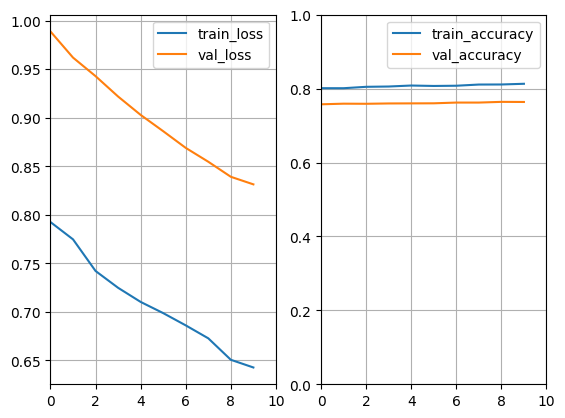

train acc:0.8130199909210205, test acc:0.7640999555587769


In [25]:
net = torch.load("model.pt")
train_loss_his, test_loss_his, train_his_acc, test_his_acc = train_model(net, num_epochs, alpha, device, batch_size)

In [26]:
#torch.save(net, "model.pt")